## Датасет


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
import torchvision

In [ ]:
from torchvision import transforms, datasets

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
dl = "18UTENzuzvwViI0c9uELD4eN4Z9W0H83b"
gdd.download_file_from_google_drive(file_id=dl, dest_path='./img_align_celeba2.zip', unzip=True)

Unzipping...Done.


In [ ]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [ ]:
!cp -R /content/img_align_celeba /content/tmp

In [ ]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [ ]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root="/content/tmp", transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset[5][0]

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         ...,
         [ 0.9843,  0.9843,  0.9922,  ...,  0.3333,  0.6706,  0.7725],
         [ 0.9686,  0.9686,  0.9765,  ...,  0.1451,  0.4431,  0.5843],
         [ 0.9922,  0.9922,  0.9843,  ..., -0.0902,  0.1059,  0.2078]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         ...,
         [ 1.0000,  1.0000,  1.0000,  ...,  0.3255,  0.6784,  0.7490],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.1137,  0.4275,  0.5686],
         [ 0.9922,  0.9922,  0.9922,  ..., -0.1373,  0.0824,  0.1922]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.8118,  0.8039,  0.7961],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


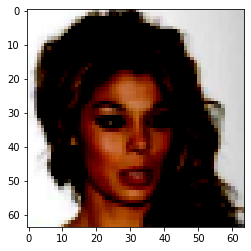

In [ ]:
show(dataset[5][0])

## Модель


In [ ]:
device = torch.device('cuda:0')

In [ ]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
    nn.ConvTranspose2d(latent_size, base_size * 16, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 16),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(base_size * 16, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(base_size * 2, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
)

In [ ]:
!pip uninstall torch 
!pip install torch
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Uninstalling torch-1.7.0+cu101:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.6/dist-packages/caffe2/*
    /usr/local/lib/python3.6/dist-packages/torch-1.7.0+cu101.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch/*
Proceed (y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/uninstall.py", line 79, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_install.py", line 755, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_uninstall.py", line 388, in remove
    if auto_confirm or self._allowed_to_procee

In [ ]:
G = G.to(device)

In [ ]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z).size()

torch.Size([1, 3, 64, 64])

In [ ]:
D = nn.Sequential(
    nn.Conv2d(num_channels, base_size, 4, 2, 1, bias=False),
    nn.ReLU(True),

    nn.Conv2d(base_size, base_size*2, 4, 2, 1, bias=False),
    nn.ReLU(True),
    nn.BatchNorm2d(base_size*2),

    nn.Conv2d(base_size*2, base_size*4, 4, 2, 1, bias=False),
    nn.ReLU(True),
    nn.BatchNorm2d(base_size*4),

    nn.Conv2d(base_size*4, base_size*8, 4, 1, 0, bias=False),
    nn.ReLU(True),
    nn.BatchNorm2d(base_size*8),

    nn.Conv2d(base_size * 8, 1, 4, 2, 0, bias=False),
    nn.Sigmoid()
  ).to(device)

In [ ]:
z = torch.randn(1, num_channels, image_size, image_size).to(device)
D(z)

tensor([[[[0.5777]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): ReLU(inplace=True)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): ReLU(inplace=True)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (12): Sigmoid()
)

In [ ]:
def draw(z):
    img = G(z).cpu()
    img = img.view((num_channels, image_size, image_size)).transpose(0, 1).transpose(1, 2).cpu().detach().numpy()
    plt.axis('off')
    plt.imshow(img.reshape(image_size, image_size, num_channels))
    plt.show()

## Обучение


In [ ]:
D.load_state_dict(torch.load('/content/drive/My Drive/D.pt')) 
G.load_state_dict(torch.load('/content/drive/My Drive/G.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0/50, 0.0
  G loss: 16.65125274658203
  D loss: 0.10278342664241791



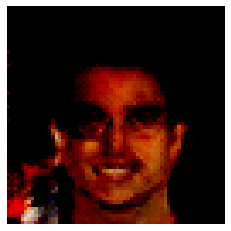

0/50, 0.07896399241945673
  G loss: 12.598546028137207
  D loss: 1.387923002243042

0/50, 0.15792798483891346
  G loss: 8.459996223449707
  D loss: 0.06300189346075058

0/50, 0.2368919772583702
  G loss: 6.415115833282471
  D loss: 0.008069343864917755

0/50, 0.3158559696778269
  G loss: 6.903434753417969
  D loss: 0.009941386058926582

0/50, 0.39481996209728365
  G loss: 7.0388288497924805
  D loss: 0.02793208882212639

0/50, 0.4737839545167404
  G loss: 16.306894302368164
  D loss: 0.013663651421666145



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


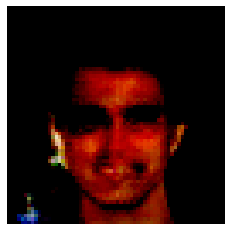

0/50, 0.5527479469361971
  G loss: 5.938042640686035
  D loss: 0.0867304652929306

0/50, 0.6317119393556538
  G loss: 5.149591445922852
  D loss: 0.09080887585878372

0/50, 0.7106759317751106
  G loss: 7.823009490966797
  D loss: 0.014059394598007202

0/50, 0.7896399241945673
  G loss: 8.870513916015625
  D loss: 0.0048530213534832

0/50, 0.868603916614024
  G loss: 10.393791198730469
  D loss: 0.1799410879611969

0/50, 0.9475679090334808
  G loss: 7.179354190826416
  D loss: 0.017563320696353912



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


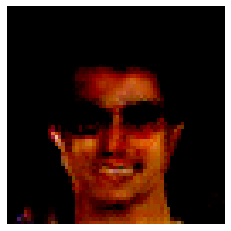

1/50, 1.0265319014529375
  G loss: 7.392146110534668
  D loss: 0.11087283492088318

1/50, 1.1054958938723942
  G loss: 11.608695983886719
  D loss: 0.0054200924932956696

1/50, 1.184459886291851
  G loss: 12.194290161132812
  D loss: 9.971254621632397e-05

1/50, 1.2634238787113077
  G loss: 10.658722877502441
  D loss: 0.2966874837875366

1/50, 1.3423878711307644
  G loss: 12.212289810180664
  D loss: 0.0033778753131628036

1/50, 1.4213518635502211
  G loss: 17.252307891845703
  D loss: 0.3286299705505371



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


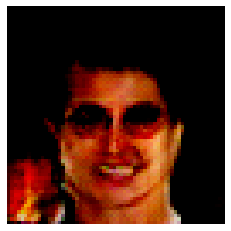

1/50, 1.5003158559696779
  G loss: 12.962175369262695
  D loss: 0.1051626205444336

1/50, 1.5792798483891346
  G loss: 7.650847911834717
  D loss: 0.009235147386789322

1/50, 1.6582438408085913
  G loss: 9.250072479248047
  D loss: 0.004653323907405138

1/50, 1.737207833228048
  G loss: 7.031907081604004
  D loss: 0.009785464964807034

1/50, 1.8161718256475048
  G loss: 11.295696258544922
  D loss: 0.046134740114212036

1/50, 1.8951358180669615
  G loss: 10.68105697631836
  D loss: 0.037255868315696716

1/50, 1.9740998104864182
  G loss: 10.975542068481445
  D loss: 0.06566771119832993



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


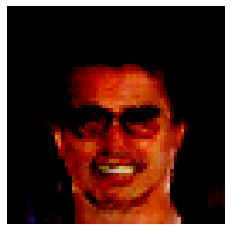

2/50, 2.053063802905875
  G loss: 8.900490760803223
  D loss: 0.1570470780134201

2/50, 2.1320277953253317
  G loss: 7.127171516418457
  D loss: 0.08908914029598236

2/50, 2.2109917877447884
  G loss: 8.643119812011719
  D loss: 0.005270151421427727

2/50, 2.289955780164245
  G loss: 8.347747802734375
  D loss: 0.032703790813684464

2/50, 2.368919772583702
  G loss: 6.956120014190674
  D loss: 0.0384221114218235

2/50, 2.4478837650031586
  G loss: 14.92098617553711
  D loss: 0.0029394098091870546



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


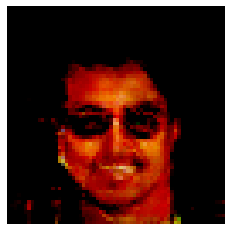

2/50, 2.5268477574226154
  G loss: 8.290996551513672
  D loss: 0.004243690986186266

2/50, 2.605811749842072
  G loss: 11.493841171264648
  D loss: 0.0021256667096167803

2/50, 2.684775742261529
  G loss: 6.430661201477051
  D loss: 0.047651030123233795

2/50, 2.7637397346809855
  G loss: 8.995420455932617
  D loss: 0.00535124447196722

2/50, 2.8427037271004423
  G loss: 14.775033950805664
  D loss: 0.00016107625560835004

2/50, 2.921667719519899
  G loss: 14.864891052246094
  D loss: 2.2956759929656982



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


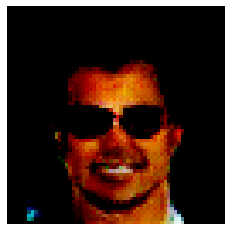

3/50, 3.0006317119393557
  G loss: 15.936356544494629
  D loss: 0.003673032857477665

3/50, 3.0795957043588125
  G loss: 9.700859069824219
  D loss: 0.008183954283595085

3/50, 3.158559696778269
  G loss: 5.898244380950928
  D loss: 0.03912798687815666

3/50, 3.237523689197726
  G loss: 7.249967575073242
  D loss: 0.011769494973123074

3/50, 3.3164876816171827
  G loss: 11.2548828125
  D loss: 0.007676003035157919

3/50, 3.3954516740366394
  G loss: 11.63481330871582
  D loss: 0.8688840270042419

3/50, 3.474415666456096
  G loss: 7.548648834228516
  D loss: 0.007290522567927837



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


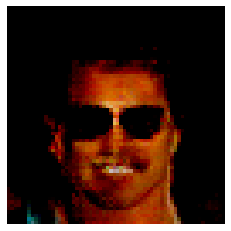

3/50, 3.553379658875553
  G loss: 11.014443397521973
  D loss: 6.480188312707469e-05

3/50, 3.6323436512950096
  G loss: 16.066638946533203
  D loss: 0.4386656582355499

3/50, 3.7113076437144663
  G loss: 9.02667236328125
  D loss: 0.0023016389459371567

3/50, 3.790271636133923
  G loss: 5.1686577796936035
  D loss: 0.11350703984498978

3/50, 3.8692356285533798
  G loss: 9.834022521972656
  D loss: 0.0011384262470528483

3/50, 3.9481996209728365
  G loss: 5.988909721374512
  D loss: 0.037294529378414154



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


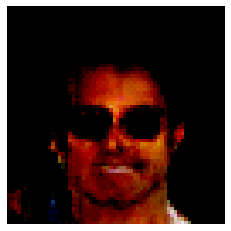

4/50, 4.027163613392293
  G loss: 4.897181510925293
  D loss: 0.0632842555642128

4/50, 4.10612760581175
  G loss: 3.70731258392334
  D loss: 1.2928156852722168

4/50, 4.185091598231207
  G loss: 7.349483489990234
  D loss: 0.004656493663787842

4/50, 4.264055590650663
  G loss: 21.334720611572266
  D loss: 0.05807655677199364

4/50, 4.34301958307012
  G loss: 10.086348533630371
  D loss: 0.004613841883838177

4/50, 4.421983575489577
  G loss: 6.774094581604004
  D loss: 0.15363775193691254



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


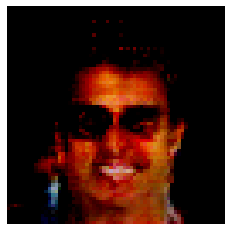

4/50, 4.500947567909034
  G loss: 9.915460586547852
  D loss: 0.0013051781570538878

4/50, 4.57991156032849
  G loss: 8.099977493286133
  D loss: 0.04619421809911728

4/50, 4.658875552747947
  G loss: 6.093739986419678
  D loss: 0.12486504763364792

4/50, 4.737839545167404
  G loss: 8.342730522155762
  D loss: 0.015794429928064346

4/50, 4.8168035375868605
  G loss: 9.882789611816406
  D loss: 0.003640265902504325

4/50, 4.895767530006317
  G loss: 9.01199722290039
  D loss: 0.22860445082187653

4/50, 4.974731522425774
  G loss: 11.019315719604492
  D loss: 0.0007586074061691761



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


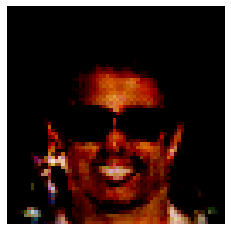

5/50, 5.053695514845231
  G loss: 10.994808197021484
  D loss: 0.002317269565537572

5/50, 5.1326595072646874
  G loss: 6.099300384521484
  D loss: 0.03872574120759964

5/50, 5.211623499684144
  G loss: 6.029613018035889
  D loss: 0.02451811544597149

5/50, 5.290587492103601
  G loss: 12.068140983581543
  D loss: 0.001445018220692873

5/50, 5.369551484523058
  G loss: 7.24288272857666
  D loss: 0.1497524380683899

5/50, 5.448515476942514
  G loss: 20.807039260864258
  D loss: 0.010617467574775219



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


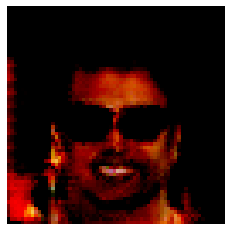

5/50, 5.527479469361971
  G loss: 12.47676944732666
  D loss: 0.1234561875462532

5/50, 5.606443461781428
  G loss: 6.189487934112549
  D loss: 0.029240533709526062

5/50, 5.685407454200885
  G loss: 7.519471168518066
  D loss: 0.06961675733327866

5/50, 5.764371446620341
  G loss: 11.701955795288086
  D loss: 0.00022547073604073375

5/50, 5.843335439039798
  G loss: 4.063635349273682
  D loss: 0.4897617697715759

5/50, 5.922299431459255
  G loss: 3.216402530670166
  D loss: 0.6414250135421753



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


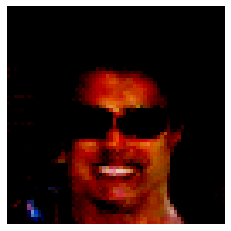

6/50, 6.0012634238787115
  G loss: 13.082754135131836
  D loss: 0.8555312752723694

6/50, 6.080227416298168
  G loss: 7.155982494354248
  D loss: 0.02237364836037159

6/50, 6.159191408717625
  G loss: 6.253373622894287
  D loss: 0.10676337778568268

6/50, 6.238155401137082
  G loss: 3.566272258758545
  D loss: 0.19826269149780273

6/50, 6.317119393556538
  G loss: 6.006032943725586
  D loss: 0.015967439860105515

6/50, 6.396083385975995
  G loss: 14.22332763671875
  D loss: 7.93970757513307e-05

6/50, 6.475047378395452
  G loss: 9.33413314819336
  D loss: 0.002828264841809869



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


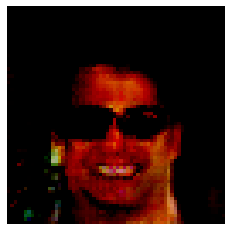

6/50, 6.554011370814909
  G loss: 19.396162033081055
  D loss: 0.006175471004098654

6/50, 6.632975363234365
  G loss: 18.421510696411133
  D loss: 0.002472955035045743

6/50, 6.711939355653822
  G loss: 10.189874649047852
  D loss: 0.0006165894446894526

6/50, 6.790903348073279
  G loss: 8.171534538269043
  D loss: 0.06198548898100853

6/50, 6.8698673404927355
  G loss: 7.496045112609863
  D loss: 0.09085521847009659

6/50, 6.948831332912192
  G loss: 6.791415214538574
  D loss: 0.03952626883983612



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


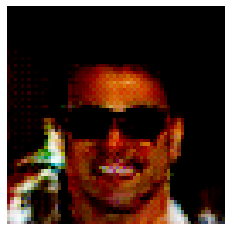

7/50, 7.027795325331649
  G loss: 12.499897956848145
  D loss: 0.00357504328712821

7/50, 7.106759317751106
  G loss: 8.599077224731445
  D loss: 0.07837173342704773

7/50, 7.185723310170562
  G loss: 14.486942291259766
  D loss: 3.3787815482355654e-05

7/50, 7.264687302590019
  G loss: 9.282522201538086
  D loss: 0.004993798211216927

7/50, 7.343651295009476
  G loss: 11.066469192504883
  D loss: 0.00016043729556258768

7/50, 7.422615287428933
  G loss: 7.673061370849609
  D loss: 0.009576376527547836



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


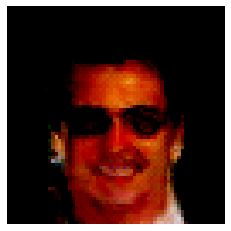

7/50, 7.501579279848389
  G loss: 10.647970199584961
  D loss: 0.023985013365745544

7/50, 7.580543272267846
  G loss: 9.24024772644043
  D loss: 0.0024987009819597006

7/50, 7.659507264687303
  G loss: 22.910926818847656
  D loss: 3.6066551208496094

7/50, 7.7384712571067595
  G loss: 9.887100219726562
  D loss: 0.0024908578488975763

7/50, 7.817435249526216
  G loss: 5.156867027282715
  D loss: 0.03437642753124237

7/50, 7.896399241945673
  G loss: 4.64689826965332
  D loss: 1.6615817546844482

7/50, 7.97536323436513
  G loss: 6.861056804656982
  D loss: 0.019178548827767372



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


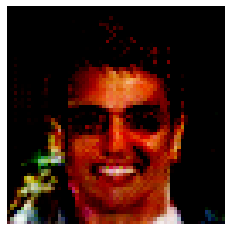

8/50, 8.054327226784586
  G loss: 10.867240905761719
  D loss: 0.05945733189582825

8/50, 8.133291219204043
  G loss: 10.207944869995117
  D loss: 0.22370950877666473

8/50, 8.2122552116235
  G loss: 9.517786026000977
  D loss: 0.004650810733437538

8/50, 8.291219204042957
  G loss: 5.464756965637207
  D loss: 0.09518694877624512

8/50, 8.370183196462413
  G loss: 6.110376358032227
  D loss: 0.0906597226858139

8/50, 8.44914718888187
  G loss: 12.022026062011719
  D loss: 0.0027221732307225466



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


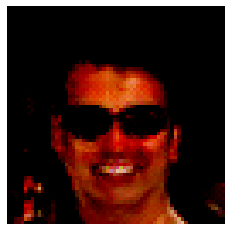

8/50, 8.528111181301327
  G loss: 0.7724142074584961
  D loss: 2.507864475250244

8/50, 8.607075173720784
  G loss: 4.1192402839660645
  D loss: 0.3090871274471283

8/50, 8.68603916614024
  G loss: 4.8651885986328125
  D loss: 0.11584175378084183

8/50, 8.765003158559697
  G loss: 6.622564315795898
  D loss: 0.0854843407869339

8/50, 8.843967150979154
  G loss: 9.456695556640625
  D loss: 0.07946138828992844

8/50, 8.92293114339861
  G loss: 15.610601425170898
  D loss: 1.3090444803237915



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


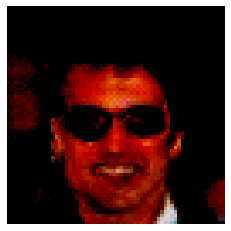

9/50, 9.001895135818067
  G loss: 8.197247505187988
  D loss: 0.04311348497867584

9/50, 9.080859128237524
  G loss: 10.271090507507324
  D loss: 0.4376971125602722

9/50, 9.15982312065698
  G loss: 15.05258846282959
  D loss: 0.014304491691291332

9/50, 9.238787113076437
  G loss: 7.500832557678223
  D loss: 0.07892141491174698

9/50, 9.317751105495894
  G loss: 11.981128692626953
  D loss: 0.10232211649417877

9/50, 9.39671509791535
  G loss: 8.700630187988281
  D loss: 0.003606768324971199

9/50, 9.475679090334808
  G loss: 6.064545631408691
  D loss: 0.05081772059202194



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


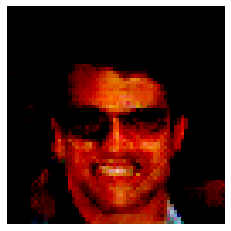

9/50, 9.554643082754264
  G loss: 11.136844635009766
  D loss: 0.02256859466433525

9/50, 9.633607075173721
  G loss: 7.078034400939941
  D loss: 0.033281028270721436

9/50, 9.712571067593178
  G loss: 11.742650985717773
  D loss: 0.10222763568162918

9/50, 9.791535060012635
  G loss: 6.751433849334717
  D loss: 0.021467020735144615

9/50, 9.870499052432091
  G loss: 6.056117057800293
  D loss: 0.023868447169661522

9/50, 9.949463044851548
  G loss: 5.848039150238037
  D loss: 0.022759316489100456



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


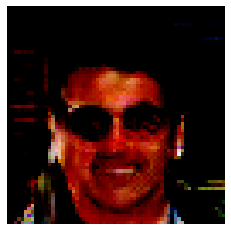

10/50, 10.028427037271005
  G loss: 4.9373931884765625
  D loss: 0.05927067995071411

10/50, 10.107391029690461
  G loss: 8.935498237609863
  D loss: 0.003737084800377488

10/50, 10.186355022109918
  G loss: 7.736123085021973
  D loss: 0.019970621913671494

10/50, 10.265319014529375
  G loss: 12.37667465209961
  D loss: 0.0001597835507709533

10/50, 10.344283006948832
  G loss: 2.8006489276885986
  D loss: 0.21421176195144653

10/50, 10.423246999368288
  G loss: 9.073570251464844
  D loss: 0.031913019716739655



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


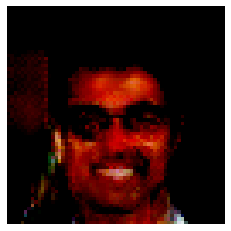

10/50, 10.502210991787745
  G loss: 12.296603202819824
  D loss: 0.005989945959299803

10/50, 10.581174984207202
  G loss: 6.671865940093994
  D loss: 1.278700351715088

10/50, 10.660138976626659
  G loss: 5.78068208694458
  D loss: 0.13784325122833252

10/50, 10.739102969046115
  G loss: 8.033788681030273
  D loss: 0.004755977541208267

10/50, 10.818066961465572
  G loss: 9.691963195800781
  D loss: 0.000607130175922066

10/50, 10.897030953885029
  G loss: 6.014007568359375
  D loss: 0.029822660610079765

10/50, 10.975994946304485
  G loss: 9.441794395446777
  D loss: 0.0016635294305160642



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


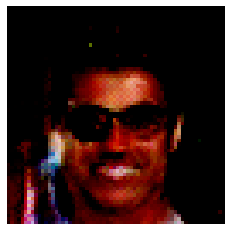

11/50, 11.054958938723942
  G loss: 9.159605026245117
  D loss: 0.06809744238853455

11/50, 11.133922931143399
  G loss: 17.076377868652344
  D loss: 0.01605720818042755

11/50, 11.212886923562856
  G loss: 13.531024932861328
  D loss: 0.0001002455028356053

11/50, 11.291850915982312
  G loss: 7.118400573730469
  D loss: 0.01674106903374195

11/50, 11.37081490840177
  G loss: 6.72906494140625
  D loss: 0.015629524365067482

11/50, 11.449778900821226
  G loss: 16.353485107421875
  D loss: 0.003759881481528282



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


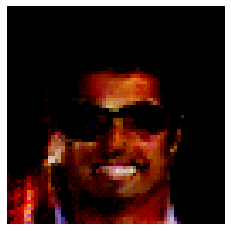

11/50, 11.528742893240683
  G loss: 9.125694274902344
  D loss: 0.0009286829736083746

11/50, 11.60770688566014
  G loss: 14.321516990661621
  D loss: 1.7602756997803226e-05

11/50, 11.686670878079596
  G loss: 13.647929191589355
  D loss: 1.635464832361322e-05

11/50, 11.765634870499053
  G loss: 12.912202835083008
  D loss: 0.017125314101576805

11/50, 11.84459886291851
  G loss: 13.455754280090332
  D loss: 0.00024006249441299587

11/50, 11.923562855337966
  G loss: 22.331348419189453
  D loss: 0.7311369180679321



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


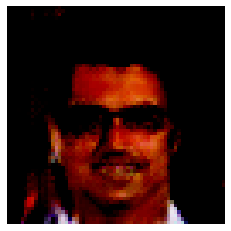

12/50, 12.002526847757423
  G loss: 7.816110134124756
  D loss: 0.01487173791974783

12/50, 12.08149084017688
  G loss: 8.399356842041016
  D loss: 0.002413238398730755

12/50, 12.160454832596336
  G loss: 14.094263076782227
  D loss: 0.010662107728421688

12/50, 12.239418825015793
  G loss: 13.323166847229004
  D loss: 0.005735139828175306

12/50, 12.31838281743525
  G loss: 11.803131103515625
  D loss: 0.44205087423324585

12/50, 12.397346809854707
  G loss: 14.675188064575195
  D loss: 0.009260880760848522

12/50, 12.476310802274163
  G loss: 12.62952995300293
  D loss: 0.010354860685765743



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


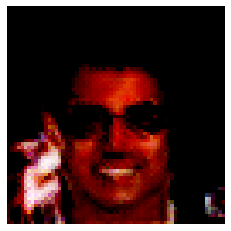

12/50, 12.55527479469362
  G loss: 11.206254959106445
  D loss: 0.001141099026426673

12/50, 12.634238787113077
  G loss: 9.743253707885742
  D loss: 0.004565713461488485

12/50, 12.713202779532534
  G loss: 4.989909648895264
  D loss: 0.04519942030310631

12/50, 12.79216677195199
  G loss: 10.911320686340332
  D loss: 0.0006877255509607494

12/50, 12.871130764371447
  G loss: 7.538278579711914
  D loss: 0.00944449845701456

12/50, 12.950094756790904
  G loss: 10.935846328735352
  D loss: 0.008255752734839916



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


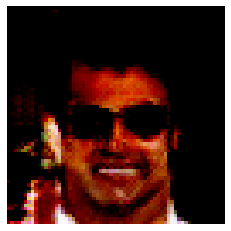

13/50, 13.02905874921036
  G loss: 8.080196380615234
  D loss: 0.06875539571046829

13/50, 13.108022741629817
  G loss: 11.014019012451172
  D loss: 0.9230157732963562

13/50, 13.186986734049274
  G loss: 12.22929573059082
  D loss: 0.0005747029790654778

13/50, 13.26595072646873
  G loss: 9.211437225341797
  D loss: 0.004722265060991049

13/50, 13.344914718888187
  G loss: 11.354103088378906
  D loss: 0.21784187853336334

13/50, 13.423878711307644
  G loss: 6.372642517089844
  D loss: 0.017913592979311943



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


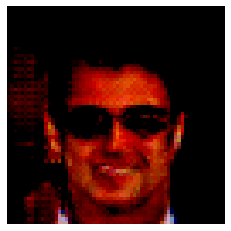

13/50, 13.5028427037271
  G loss: 9.556933403015137
  D loss: 0.0008471102337352931

13/50, 13.581806696146558
  G loss: 11.053916931152344
  D loss: 0.0004339364531915635

13/50, 13.660770688566014
  G loss: 6.7325439453125
  D loss: 0.055934544652700424

13/50, 13.739734680985471
  G loss: 10.933650016784668
  D loss: 2.6082847118377686

13/50, 13.818698673404928
  G loss: 9.902694702148438
  D loss: 0.0015080786542966962

13/50, 13.897662665824384
  G loss: 9.227509498596191
  D loss: 0.0006675700424239039

13/50, 13.976626658243841
  G loss: 15.958938598632812
  D loss: 0.0015277425991371274



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


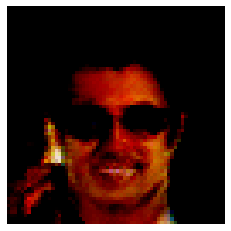

14/50, 14.055590650663298
  G loss: 6.766587734222412
  D loss: 0.003494551172479987

14/50, 14.134554643082755
  G loss: 11.124723434448242
  D loss: 0.0002885173016693443

14/50, 14.213518635502211
  G loss: 13.3336181640625
  D loss: 0.010292659513652325

14/50, 14.292482627921668
  G loss: 7.444159507751465
  D loss: 0.002076653763651848

14/50, 14.371446620341125
  G loss: 8.045635223388672
  D loss: 0.016928929835557938

14/50, 14.450410612760582
  G loss: 11.685752868652344
  D loss: 0.0003352135536260903



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


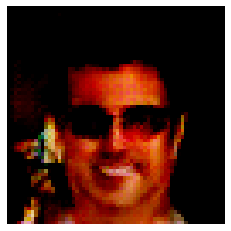

14/50, 14.529374605180038
  G loss: 7.708448886871338
  D loss: 0.1769687533378601

14/50, 14.608338597599495
  G loss: 6.016551971435547
  D loss: 0.34025248885154724

14/50, 14.687302590018952
  G loss: 8.408697128295898
  D loss: 0.00016320224676746875

14/50, 14.766266582438409
  G loss: 9.819303512573242
  D loss: 0.0010234517976641655

14/50, 14.845230574857865
  G loss: 13.270960807800293
  D loss: 0.09310338646173477

14/50, 14.924194567277322
  G loss: 7.4353108406066895
  D loss: 0.01324293203651905



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


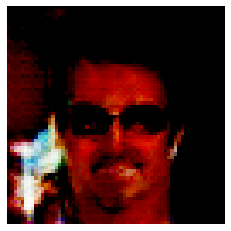

15/50, 15.003158559696779
  G loss: 9.82363510131836
  D loss: 0.19420869648456573

15/50, 15.082122552116235
  G loss: 6.864286422729492
  D loss: 0.00800216756761074

15/50, 15.161086544535692
  G loss: 13.586034774780273
  D loss: 0.00609938707202673

15/50, 15.240050536955149
  G loss: 10.430922508239746
  D loss: 0.0001362708571832627

15/50, 15.319014529374606
  G loss: 15.62132453918457
  D loss: 0.004571849480271339

15/50, 15.397978521794062
  G loss: 9.566804885864258
  D loss: 0.03210477903485298

15/50, 15.476942514213519
  G loss: 6.440676689147949
  D loss: 0.012565470300614834



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


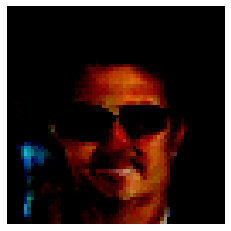

15/50, 15.555906506632976
  G loss: 11.033048629760742
  D loss: 0.0014056682121008635

15/50, 15.634870499052433
  G loss: 8.42860221862793
  D loss: 0.0020487525034695864

15/50, 15.71383449147189
  G loss: 12.22885513305664
  D loss: 0.04820656031370163

15/50, 15.792798483891346
  G loss: 2.6881799697875977
  D loss: 3.359376907348633

15/50, 15.871762476310803
  G loss: 9.852437019348145
  D loss: 0.3879503011703491

15/50, 15.95072646873026
  G loss: 11.221332550048828
  D loss: 0.000530090241227299



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


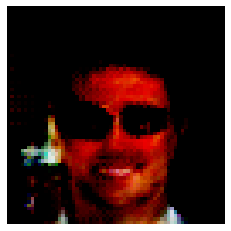

16/50, 16.029690461149716
  G loss: 6.474050998687744
  D loss: 0.1912122368812561

16/50, 16.108654453569173
  G loss: 21.581260681152344
  D loss: 0.09652698785066605

16/50, 16.18761844598863
  G loss: 9.348348617553711
  D loss: 0.034027762711048126

16/50, 16.266582438408086
  G loss: 9.619024276733398
  D loss: 0.003902868600562215

16/50, 16.345546430827543
  G loss: 5.136486530303955
  D loss: 0.1028236523270607

16/50, 16.424510423247
  G loss: 7.890712738037109
  D loss: 0.002743832767009735



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


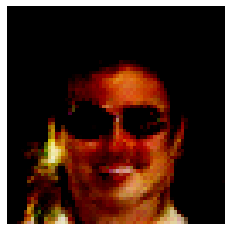

16/50, 16.503474415666457
  G loss: 5.640378952026367
  D loss: 0.08322826027870178

16/50, 16.582438408085913
  G loss: 7.914643287658691
  D loss: 0.02395911142230034

16/50, 16.66140240050537
  G loss: 6.275636672973633
  D loss: 0.025547685101628304

16/50, 16.740366392924827
  G loss: 12.081501960754395
  D loss: 0.009620931930840015

16/50, 16.819330385344283
  G loss: 11.322349548339844
  D loss: 0.38476842641830444

16/50, 16.89829437776374
  G loss: 9.63158130645752
  D loss: 0.00121901067905128

16/50, 16.977258370183197
  G loss: 5.699410915374756
  D loss: 0.005344674922525883



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


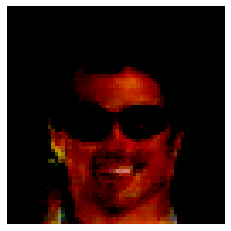

17/50, 17.056222362602654
  G loss: 9.284627914428711
  D loss: 0.018706507980823517

17/50, 17.13518635502211
  G loss: 11.746184349060059
  D loss: 0.0010347520001232624

17/50, 17.214150347441567
  G loss: 6.200217247009277
  D loss: 0.015686629340052605

17/50, 17.293114339861024
  G loss: 8.28579330444336
  D loss: 1.5650770664215088

17/50, 17.37207833228048
  G loss: 9.86042594909668
  D loss: 0.0014283545315265656

17/50, 17.451042324699937
  G loss: 12.284772872924805
  D loss: 0.0001867133833002299



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


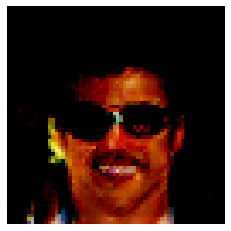

17/50, 17.530006317119394
  G loss: 13.257621765136719
  D loss: 0.10234594345092773

17/50, 17.60897030953885
  G loss: 7.437547206878662
  D loss: 0.09534458816051483

17/50, 17.687934301958308
  G loss: 8.29102897644043
  D loss: 0.2838341295719147

17/50, 17.766898294377764
  G loss: 11.335014343261719
  D loss: 0.0027037847321480513

17/50, 17.84586228679722
  G loss: 17.746776580810547
  D loss: 0.4222009479999542

17/50, 17.924826279216678
  G loss: 6.926185131072998
  D loss: 0.006357952952384949



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


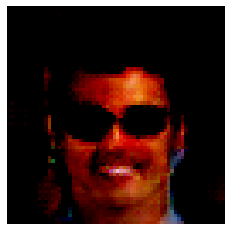

18/50, 18.003790271636134
  G loss: 3.9997851848602295
  D loss: 0.09278294444084167

18/50, 18.08275426405559
  G loss: 11.219831466674805
  D loss: 8.95703851711005e-05

18/50, 18.161718256475048
  G loss: 12.491250991821289
  D loss: 0.00015332348993979394

18/50, 18.240682248894505
  G loss: 11.452133178710938
  D loss: 0.019760489463806152

18/50, 18.31964624131396
  G loss: 17.34981918334961
  D loss: 0.0015783386770635843

18/50, 18.398610233733418
  G loss: 9.224300384521484
  D loss: 0.0009781226981431246

18/50, 18.477574226152875
  G loss: 8.074420928955078
  D loss: 0.018538717180490494



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


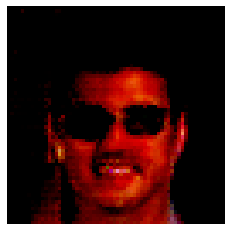

18/50, 18.55653821857233
  G loss: 7.838092803955078
  D loss: 0.030771683901548386

18/50, 18.63550221099179
  G loss: 6.544891357421875
  D loss: 0.018460432067513466

18/50, 18.714466203411245
  G loss: 11.55656623840332
  D loss: 0.0025911249686032534

18/50, 18.7934301958307
  G loss: 9.405496597290039
  D loss: 0.0059914374724030495

18/50, 18.87239418825016
  G loss: 11.984723091125488
  D loss: 0.018974512815475464

18/50, 18.951358180669615
  G loss: 16.626327514648438
  D loss: 3.2346964871976525e-05



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


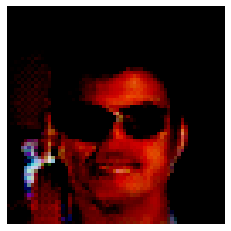

19/50, 19.030322173089072
  G loss: 12.977348327636719
  D loss: 2.1265288523864e-05

19/50, 19.10928616550853
  G loss: 11.689300537109375
  D loss: 0.009027102030813694

19/50, 19.188250157927985
  G loss: 10.881763458251953
  D loss: 0.0011956902453675866

19/50, 19.267214150347442
  G loss: 13.53321647644043
  D loss: 2.9467286367435008e-05

19/50, 19.3461781427669
  G loss: 7.672662258148193
  D loss: 0.013148700818419456

19/50, 19.425142135186356
  G loss: 8.884588241577148
  D loss: 0.029019679874181747



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


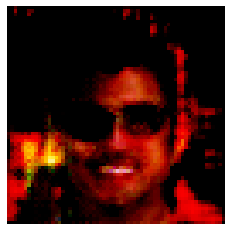

19/50, 19.504106127605812
  G loss: 9.52029037475586
  D loss: 0.00237369816750288

19/50, 19.58307012002527
  G loss: 8.961522102355957
  D loss: 0.01352914609014988

19/50, 19.662034112444726
  G loss: 8.504194259643555
  D loss: 0.0011500980472192168

19/50, 19.740998104864182
  G loss: 8.11121940612793
  D loss: 0.007246782071888447

19/50, 19.81996209728364
  G loss: 6.914320945739746
  D loss: 0.008616754785180092

19/50, 19.898926089703096
  G loss: 13.529858589172363
  D loss: 0.0009552441188134253

19/50, 19.977890082122553
  G loss: 1.766930341720581
  D loss: 5.056312561035156



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


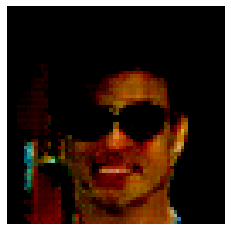

20/50, 20.05685407454201
  G loss: 7.3130998611450195
  D loss: 0.017780866473913193

20/50, 20.135818066961466
  G loss: 12.029006004333496
  D loss: 1.4640486240386963

20/50, 20.214782059380923
  G loss: 10.998570442199707
  D loss: 0.1293422430753708

20/50, 20.29374605180038
  G loss: 4.817894458770752
  D loss: 0.2807840406894684

20/50, 20.372710044219836
  G loss: 11.194499969482422
  D loss: 0.011190011166036129

20/50, 20.451674036639293
  G loss: 4.69502592086792
  D loss: 0.14008308947086334



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


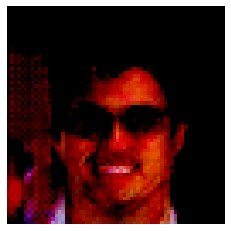

20/50, 20.53063802905875
  G loss: 5.9167938232421875
  D loss: 0.5516486763954163

20/50, 20.609602021478207
  G loss: 9.32458782196045
  D loss: 0.07922561466693878

20/50, 20.688566013897663
  G loss: 11.1746244430542
  D loss: 0.0020519352983683348

20/50, 20.76753000631712
  G loss: 7.689516544342041
  D loss: 0.007825634442269802

20/50, 20.846493998736577
  G loss: 8.811823844909668
  D loss: 0.0006338841049000621

20/50, 20.925457991156033
  G loss: 5.54196834564209
  D loss: 0.19917047023773193



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


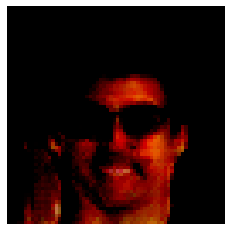

21/50, 21.00442198357549
  G loss: 6.193960189819336
  D loss: 0.22335070371627808

21/50, 21.083385975994947
  G loss: 1.791375994682312
  D loss: 0.1442975550889969

21/50, 21.162349968414404
  G loss: 9.063772201538086
  D loss: 0.06738514453172684

21/50, 21.24131396083386
  G loss: 11.695219993591309
  D loss: 0.00011060758697567508

21/50, 21.320277953253317
  G loss: 8.31704044342041
  D loss: 0.00647619366645813

21/50, 21.399241945672774
  G loss: 12.385372161865234
  D loss: 0.011669386178255081

21/50, 21.47820593809223
  G loss: 9.609193801879883
  D loss: 0.01978696510195732



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


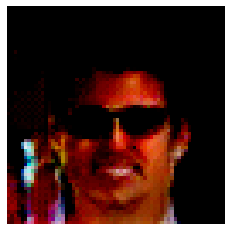

21/50, 21.557169930511687
  G loss: 9.437052726745605
  D loss: 0.004237739834934473

21/50, 21.636133922931144
  G loss: 7.082612037658691
  D loss: 0.004591113887727261

21/50, 21.7150979153506
  G loss: 10.52724838256836
  D loss: 0.0003731428296305239

21/50, 21.794061907770057
  G loss: 9.235079765319824
  D loss: 0.09474249184131622

21/50, 21.873025900189514
  G loss: 7.595247268676758
  D loss: 0.031313955783843994

21/50, 21.95198989260897
  G loss: 3.7792534828186035
  D loss: 0.21963994204998016



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


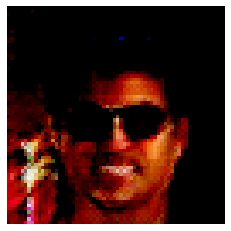

22/50, 22.030953885028428
  G loss: 15.016595840454102
  D loss: 0.040461573749780655

22/50, 22.109917877447884
  G loss: 10.113197326660156
  D loss: 0.0004631778283510357

22/50, 22.18888186986734
  G loss: 9.344656944274902
  D loss: 0.001363714225590229

22/50, 22.267845862286798
  G loss: 11.40467643737793
  D loss: 0.004636503290385008

22/50, 22.346809854706255
  G loss: 9.214677810668945
  D loss: 0.17141193151474

22/50, 22.42577384712571
  G loss: 8.32618522644043
  D loss: 0.163640558719635



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


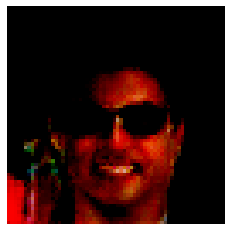

22/50, 22.504737839545168
  G loss: 9.789182662963867
  D loss: 0.08173651993274689

22/50, 22.583701831964625
  G loss: 6.758160591125488
  D loss: 0.009779169224202633

22/50, 22.66266582438408
  G loss: 12.849187850952148
  D loss: 0.0005046525620855391

22/50, 22.74162981680354
  G loss: 7.54640007019043
  D loss: 0.0030478741973638535

22/50, 22.820593809222995
  G loss: 17.236072540283203
  D loss: 0.45052212476730347

22/50, 22.89955780164245
  G loss: 11.381555557250977
  D loss: 0.0020157299004495144

22/50, 22.97852179406191
  G loss: 5.525467872619629
  D loss: 0.22719016671180725



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


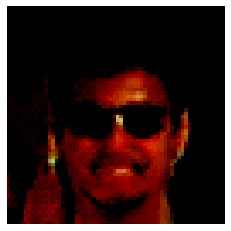

23/50, 23.057485786481365
  G loss: 14.061009407043457
  D loss: 0.005937449634075165

23/50, 23.136449778900822
  G loss: 11.527536392211914
  D loss: 0.013435812667012215

23/50, 23.21541377132028
  G loss: 12.668623924255371
  D loss: 0.005177685525268316

23/50, 23.294377763739735
  G loss: 6.971026420593262
  D loss: 0.01881624385714531

23/50, 23.373341756159192
  G loss: 9.73964786529541
  D loss: 0.0890904888510704

23/50, 23.45230574857865
  G loss: 13.73736572265625
  D loss: 0.0017747207311913371



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


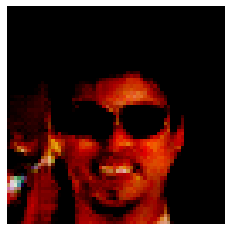

23/50, 23.531269740998106
  G loss: 10.498007774353027
  D loss: 0.01194727048277855

23/50, 23.610233733417562
  G loss: 12.181283950805664
  D loss: 0.004641236737370491

23/50, 23.68919772583702
  G loss: 7.091274261474609
  D loss: 0.004595216363668442

23/50, 23.768161718256476
  G loss: 7.292500972747803
  D loss: 0.14365838468074799

23/50, 23.847125710675932
  G loss: 9.76485824584961
  D loss: 0.0019648608285933733

23/50, 23.92608970309539
  G loss: 13.295633316040039
  D loss: 0.20090828835964203



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


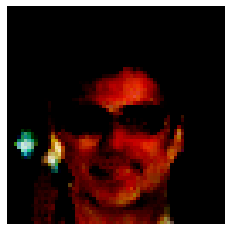

24/50, 24.005053695514846
  G loss: 12.139274597167969
  D loss: 7.196253136498854e-05

24/50, 24.084017687934303
  G loss: 11.991720199584961
  D loss: 0.01254340261220932

24/50, 24.16298168035376
  G loss: 12.184564590454102
  D loss: 0.002560189925134182

24/50, 24.241945672773216
  G loss: 9.487468719482422
  D loss: 0.03400453180074692

24/50, 24.320909665192673
  G loss: 5.882603168487549
  D loss: 0.022896697744727135

24/50, 24.39987365761213
  G loss: 5.962763786315918
  D loss: 0.13064244389533997

24/50, 24.478837650031586
  G loss: 3.957418203353882
  D loss: 0.3210829794406891



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


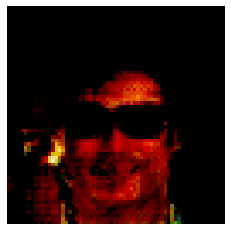

24/50, 24.557801642451043
  G loss: 7.241081237792969
  D loss: 0.004800194408744574

24/50, 24.6367656348705
  G loss: 9.108736038208008
  D loss: 0.02867848426103592

24/50, 24.715729627289956
  G loss: 9.20518684387207
  D loss: 0.12250983715057373

24/50, 24.794693619709413
  G loss: 4.600123405456543
  D loss: 0.08994242548942566

24/50, 24.87365761212887
  G loss: 8.068845748901367
  D loss: 0.18635611236095428

24/50, 24.952621604548327
  G loss: 9.239717483520508
  D loss: 0.031843479722738266



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


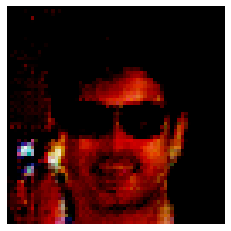

25/50, 25.031585596967783
  G loss: 8.933433532714844
  D loss: 0.02035195380449295

25/50, 25.11054958938724
  G loss: 6.5396013259887695
  D loss: 0.012477988377213478

25/50, 25.189513581806697
  G loss: 10.066877365112305
  D loss: 0.0020114583894610405

25/50, 25.268477574226154
  G loss: 8.09184455871582
  D loss: 0.25673577189445496

25/50, 25.34744156664561
  G loss: 4.376614093780518
  D loss: 0.3775688409805298

25/50, 25.426405559065067
  G loss: 13.049535751342773
  D loss: 0.04805774986743927



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


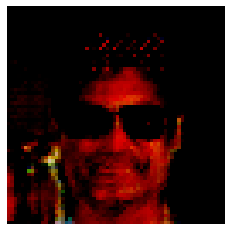

25/50, 25.505369551484524
  G loss: 5.203333854675293
  D loss: 0.10845243185758591

25/50, 25.58433354390398
  G loss: 9.589099884033203
  D loss: 0.016016418114304543

25/50, 25.663297536323437
  G loss: 8.589399337768555
  D loss: 0.013129426166415215

25/50, 25.742261528742894
  G loss: 12.101032257080078
  D loss: 0.00017761331400834024

25/50, 25.82122552116235
  G loss: 9.362823486328125
  D loss: 0.012366109527647495

25/50, 25.900189513581807
  G loss: 7.851471900939941
  D loss: 0.017353177070617676

25/50, 25.979153506001264
  G loss: 17.78884506225586
  D loss: 0.06231572479009628



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


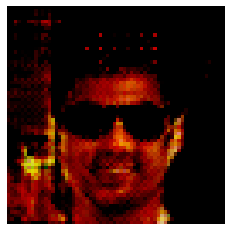

26/50, 26.05811749842072
  G loss: 10.052828788757324
  D loss: 0.002014098223298788

26/50, 26.137081490840178
  G loss: 13.373531341552734
  D loss: 0.0025924392975866795

26/50, 26.216045483259634
  G loss: 14.106268882751465
  D loss: 5.046691876486875e-05

26/50, 26.29500947567909
  G loss: 15.510760307312012
  D loss: 0.09211108088493347

26/50, 26.373973468098548
  G loss: 2.818796157836914
  D loss: 0.9678104519844055

26/50, 26.452937460518005
  G loss: 9.992298126220703
  D loss: 0.05617193132638931



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


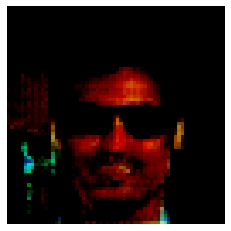

26/50, 26.53190145293746
  G loss: 4.094876289367676
  D loss: 0.7845257520675659

26/50, 26.610865445356918
  G loss: 8.069206237792969
  D loss: 0.016547083854675293

26/50, 26.689829437776375
  G loss: 14.280410766601562
  D loss: 0.0579511821269989

26/50, 26.76879343019583
  G loss: 9.350842475891113
  D loss: 0.03250788897275925

26/50, 26.847757422615288
  G loss: 6.237042427062988
  D loss: 0.12687605619430542

26/50, 26.926721415034745
  G loss: 7.822854995727539
  D loss: 0.06718664616346359



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


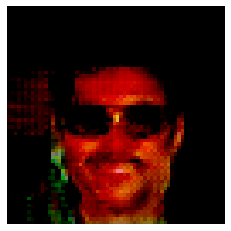

27/50, 27.0056854074542
  G loss: 5.547363758087158
  D loss: 1.0009253025054932

27/50, 27.08464939987366
  G loss: 5.766323089599609
  D loss: 0.04695186764001846

27/50, 27.163613392293115
  G loss: 6.552995681762695
  D loss: 0.018823083490133286

27/50, 27.242577384712572
  G loss: 8.111210823059082
  D loss: 0.04789552465081215

27/50, 27.32154137713203
  G loss: 4.3643341064453125
  D loss: 0.07690849900245667

27/50, 27.400505369551485
  G loss: 6.670809745788574
  D loss: 0.00741349533200264

27/50, 27.479469361970942
  G loss: 6.779684066772461
  D loss: 0.09036656469106674



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


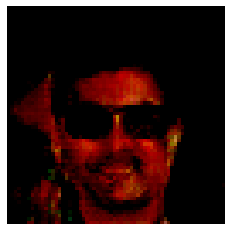

27/50, 27.5584333543904
  G loss: 12.400712966918945
  D loss: 0.024512747302651405

27/50, 27.637397346809855
  G loss: 6.625136375427246
  D loss: 0.025039996951818466

27/50, 27.716361339229312
  G loss: 8.221822738647461
  D loss: 0.0334758423268795

27/50, 27.79532533164877
  G loss: 11.934427261352539
  D loss: 0.011673551052808762

27/50, 27.874289324068226
  G loss: 13.93889331817627
  D loss: 0.0002748377446550876

27/50, 27.953253316487682
  G loss: 8.395426750183105
  D loss: 0.04514077678322792



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


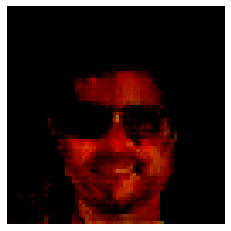

28/50, 28.03221730890714
  G loss: 12.96827507019043
  D loss: 0.0008269184618256986

28/50, 28.111181301326596
  G loss: 10.038824081420898
  D loss: 0.022334497421979904

28/50, 28.190145293746053
  G loss: 6.456822872161865
  D loss: 0.05071314051747322

28/50, 28.26910928616551
  G loss: 5.794983863830566
  D loss: 0.07335621118545532

28/50, 28.348073278584966
  G loss: 12.912911415100098
  D loss: 0.00036343061947263777

28/50, 28.427037271004423
  G loss: 19.382596969604492
  D loss: 7.817167352186516e-05



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


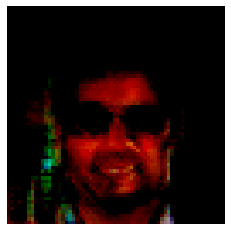

28/50, 28.50600126342388
  G loss: 11.894465446472168
  D loss: 0.00562739372253418

28/50, 28.584965255843336
  G loss: 7.844658374786377
  D loss: 0.053277213126420975

28/50, 28.663929248262793
  G loss: 5.174983978271484
  D loss: 0.09786232560873032

28/50, 28.74289324068225
  G loss: 9.51927661895752
  D loss: 0.08336562663316727

28/50, 28.821857233101706
  G loss: 7.6983842849731445
  D loss: 0.4593178331851959

28/50, 28.900821225521163
  G loss: 4.125284194946289
  D loss: 0.26322776079177856

28/50, 28.97978521794062
  G loss: 7.395748138427734
  D loss: 0.02029888704419136



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


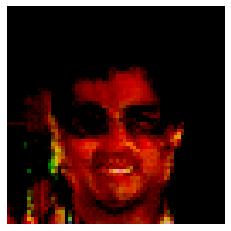

29/50, 29.058749210360077
  G loss: 14.973188400268555
  D loss: 0.0767362043261528

29/50, 29.137713202779533
  G loss: 13.101917266845703
  D loss: 0.014039655216038227

29/50, 29.21667719519899
  G loss: 10.798493385314941
  D loss: 0.015176455490291119

29/50, 29.295641187618447
  G loss: 8.415565490722656
  D loss: 0.0033092200756073

29/50, 29.374605180037904
  G loss: 9.89528751373291
  D loss: 0.00512632867321372

29/50, 29.45356917245736
  G loss: 16.95911407470703
  D loss: 0.010167967528104782



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


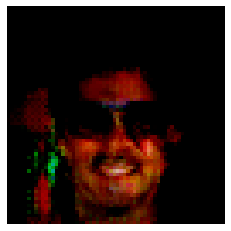

29/50, 29.532533164876817
  G loss: 6.696882724761963
  D loss: 0.01652286946773529

29/50, 29.611497157296274
  G loss: 4.663628578186035
  D loss: 0.602017879486084

29/50, 29.69046114971573
  G loss: 5.345325469970703
  D loss: 0.0781530886888504

29/50, 29.769425142135187
  G loss: 16.945711135864258
  D loss: 0.33931824564933777

29/50, 29.848389134554644
  G loss: 13.137001037597656
  D loss: 0.0013446740340441465

29/50, 29.9273531269741
  G loss: 4.543106555938721
  D loss: 0.27770861983299255



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


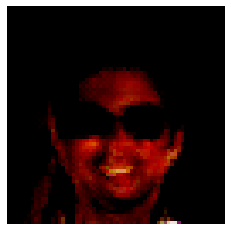

30/50, 30.006317119393557
  G loss: 10.070150375366211
  D loss: 0.007021523546427488

30/50, 30.085281111813014
  G loss: 13.127037048339844
  D loss: 0.0019691039342433214

30/50, 30.16424510423247
  G loss: 14.553359031677246
  D loss: 4.905747118755244e-05

30/50, 30.243209096651928
  G loss: 9.226543426513672
  D loss: 0.00428381422534585

30/50, 30.322173089071384
  G loss: 6.826704025268555
  D loss: 0.055014126002788544

30/50, 30.40113708149084
  G loss: 4.78593635559082
  D loss: 0.06925053149461746

30/50, 30.480101073910298
  G loss: 11.683008193969727
  D loss: 0.00022598690702579916



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


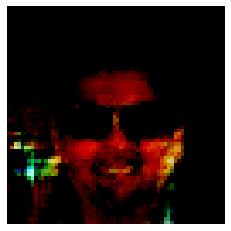

30/50, 30.559065066329755
  G loss: 6.227977752685547
  D loss: 0.1829659640789032

30/50, 30.63802905874921
  G loss: 7.134471416473389
  D loss: 0.02974454127252102

30/50, 30.716993051168668
  G loss: 7.920902252197266
  D loss: 0.05073092132806778

30/50, 30.795957043588125
  G loss: 6.396603584289551
  D loss: 0.019807808101177216

30/50, 30.87492103600758
  G loss: 13.46375560760498
  D loss: 0.0006570095429196954

30/50, 30.953885028427038
  G loss: 7.804150104522705
  D loss: 0.008314469829201698



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


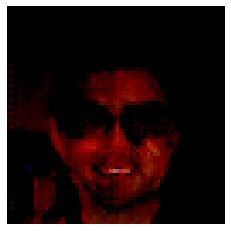

31/50, 31.032849020846495
  G loss: 8.857707977294922
  D loss: 0.022935157641768456

31/50, 31.11181301326595
  G loss: 10.112081527709961
  D loss: 0.000996565562672913

31/50, 31.19077700568541
  G loss: 9.790580749511719
  D loss: 0.09998852014541626

31/50, 31.269740998104865
  G loss: 7.973043441772461
  D loss: 0.561581552028656

31/50, 31.348704990524322
  G loss: 11.881146430969238
  D loss: 0.027163006365299225

31/50, 31.42766898294378
  G loss: 11.890396118164062
  D loss: 0.004059283062815666



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


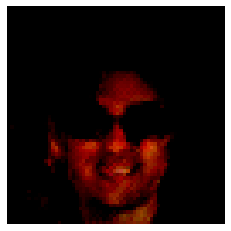

31/50, 31.506632975363235
  G loss: 10.956756591796875
  D loss: 0.001987860072404146

31/50, 31.585596967782692
  G loss: 11.728334426879883
  D loss: 0.0024021368008106947

31/50, 31.66456096020215
  G loss: 8.564239501953125
  D loss: 0.0055110864341259

31/50, 31.743524952621605
  G loss: 8.11638069152832
  D loss: 0.024385731667280197

31/50, 31.822488945041062
  G loss: 11.381473541259766
  D loss: 0.001386823714710772

31/50, 31.90145293746052
  G loss: 9.413119316101074
  D loss: 0.00041754721314646304

31/50, 31.980416929879976
  G loss: 5.3503546714782715
  D loss: 0.24068842828273773



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


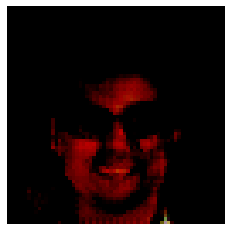

32/50, 32.05938092229943
  G loss: 12.195658683776855
  D loss: 0.0011628505308181047

32/50, 32.138344914718886
  G loss: 7.434106349945068
  D loss: 0.04267766699194908

32/50, 32.217308907138346
  G loss: 11.102526664733887
  D loss: 0.0040899766609072685

32/50, 32.2962728995578
  G loss: 12.161537170410156
  D loss: 0.028690261766314507

32/50, 32.37523689197726
  G loss: 9.627445220947266
  D loss: 0.0019670254550874233

32/50, 32.45420088439671
  G loss: 12.777530670166016
  D loss: 5.50680051674135e-05



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


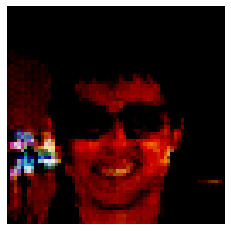

32/50, 32.53316487681617
  G loss: 5.509061813354492
  D loss: 0.14675860106945038

32/50, 32.612128869235626
  G loss: 6.956192970275879
  D loss: 0.050607312470674515

32/50, 32.691092861655086
  G loss: 11.71992301940918
  D loss: 0.0002735972811933607

32/50, 32.77005685407454
  G loss: 7.648153305053711
  D loss: 0.028613317757844925

32/50, 32.849020846494
  G loss: 12.987415313720703
  D loss: 0.21483881771564484

32/50, 32.92798483891345
  G loss: 12.5383939743042
  D loss: 2.5478202587692067e-05



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


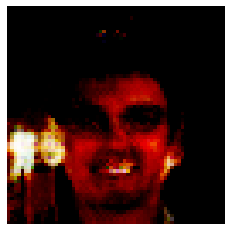

33/50, 33.00694883133291
  G loss: 10.71428108215332
  D loss: 0.00657934695482254

33/50, 33.085912823752366
  G loss: 3.012809991836548
  D loss: 0.05289849266409874

33/50, 33.16487681617183
  G loss: 13.876587867736816
  D loss: 0.0010422492632642388

33/50, 33.24384080859128
  G loss: 10.019063949584961
  D loss: 0.013492760248482227

33/50, 33.32280480101074
  G loss: 10.711414337158203
  D loss: 0.01319338008761406

33/50, 33.40176879343019
  G loss: 8.978044509887695
  D loss: 0.0027844677679240704

33/50, 33.48073278584965
  G loss: 13.313529968261719
  D loss: 0.0002777349145617336



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


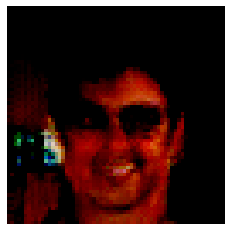

33/50, 33.55969677826911
  G loss: 12.039104461669922
  D loss: 0.0002795568434521556

33/50, 33.63866077068857
  G loss: 4.522535800933838
  D loss: 0.4753260612487793

33/50, 33.71762476310802
  G loss: 3.0180838108062744
  D loss: 0.29295647144317627

33/50, 33.79658875552748
  G loss: 4.406803607940674
  D loss: 0.32424092292785645

33/50, 33.875552747946934
  G loss: 11.734854698181152
  D loss: 0.12550704181194305

33/50, 33.954516740366394
  G loss: 4.7304792404174805
  D loss: 0.5260934829711914



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


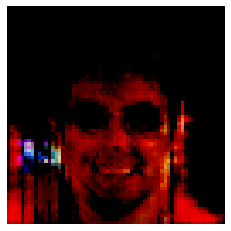

34/50, 34.03348073278585
  G loss: 3.609096050262451
  D loss: 3.3549153804779053

34/50, 34.11244472520531
  G loss: 8.479193687438965
  D loss: 0.0023966317530721426

34/50, 34.19140871762476
  G loss: 6.78911018371582
  D loss: 0.03836604207754135

34/50, 34.27037271004422
  G loss: 6.812482833862305
  D loss: 0.056221432983875275

34/50, 34.349336702463674
  G loss: 15.627894401550293
  D loss: 0.0004441827768459916

34/50, 34.428300694883134
  G loss: 10.17120361328125
  D loss: 0.027243297547101974



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


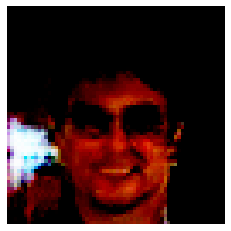

34/50, 34.50726468730259
  G loss: 11.756569862365723
  D loss: 0.0026326326187700033

34/50, 34.58622867972205
  G loss: 13.840442657470703
  D loss: 0.027252178639173508

34/50, 34.6651926721415
  G loss: 10.412103652954102
  D loss: 0.007825232110917568

34/50, 34.74415666456096
  G loss: 9.29798698425293
  D loss: 0.001446401234716177

34/50, 34.823120656980414
  G loss: 13.182490348815918
  D loss: 0.10712756961584091

34/50, 34.902084649399875
  G loss: 5.919206619262695
  D loss: 0.053127653896808624

34/50, 34.98104864181933
  G loss: 4.978569984436035
  D loss: 0.17087239027023315



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


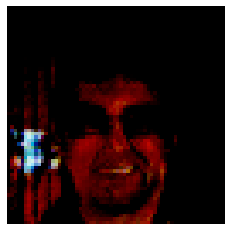

35/50, 35.06001263423879
  G loss: 10.52572250366211
  D loss: 0.003515315940603614

35/50, 35.13897662665824
  G loss: 7.959486961364746
  D loss: 0.01691124588251114

35/50, 35.2179406190777
  G loss: 6.468255043029785
  D loss: 0.029449699446558952

35/50, 35.296904611497155
  G loss: 16.15784454345703
  D loss: 0.06348299235105515

35/50, 35.375868603916615
  G loss: 12.25434684753418
  D loss: 0.0006317254155874252

35/50, 35.45483259633607
  G loss: 7.978565216064453
  D loss: 0.06800059974193573



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


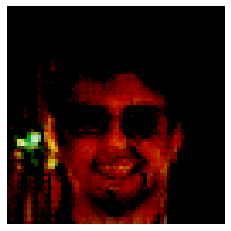

35/50, 35.53379658875553
  G loss: 9.339685440063477
  D loss: 0.0017827623523771763

35/50, 35.61276058117498
  G loss: 9.481866836547852
  D loss: 0.07640578597784042

35/50, 35.69172457359444
  G loss: 11.455446243286133
  D loss: 0.00603141076862812

35/50, 35.770688566013895
  G loss: 7.767604827880859
  D loss: 0.0036192145198583603

35/50, 35.849652558433355
  G loss: 9.427013397216797
  D loss: 0.009127415716648102

35/50, 35.92861655085281
  G loss: 10.456981658935547
  D loss: 0.016334310173988342



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


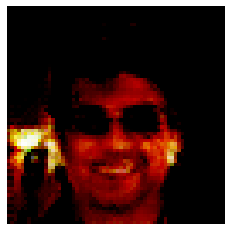

36/50, 36.00758054327227
  G loss: 13.015693664550781
  D loss: 0.0001375183928757906

36/50, 36.08654453569172
  G loss: 12.138742446899414
  D loss: 0.0005978381959721446

36/50, 36.16550852811118
  G loss: 7.68386697769165
  D loss: 0.005643039010465145

36/50, 36.244472520530636
  G loss: 13.87252426147461
  D loss: 0.04391570761799812

36/50, 36.323436512950096
  G loss: 13.383740425109863
  D loss: 0.0022345713805407286

36/50, 36.40240050536955
  G loss: 8.837593078613281
  D loss: 0.0026475354097783566

36/50, 36.48136449778901
  G loss: 16.864418029785156
  D loss: 7.693567022215575e-05



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


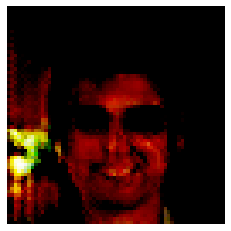

36/50, 36.56032849020846
  G loss: 7.098779678344727
  D loss: 0.04259224236011505

36/50, 36.63929248262792
  G loss: 10.056371688842773
  D loss: 0.00250932015478611

36/50, 36.718256475047376
  G loss: 9.830717086791992
  D loss: 0.9702766537666321

36/50, 36.797220467466836
  G loss: 9.20712661743164
  D loss: 0.002716550137847662

36/50, 36.87618445988629
  G loss: 9.136344909667969
  D loss: 0.0040680780075490475

36/50, 36.95514845230575
  G loss: 11.442863464355469
  D loss: 0.0020883081015199423



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


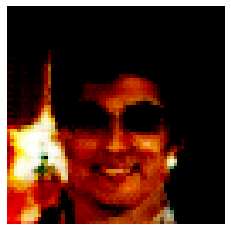

37/50, 37.0341124447252
  G loss: 7.92221736907959
  D loss: 0.026118651032447815

37/50, 37.11307643714466
  G loss: 16.143531799316406
  D loss: 0.0019067416433244944

37/50, 37.192040429564116
  G loss: 19.03795623779297
  D loss: 0.00020674073311965913

37/50, 37.27100442198358
  G loss: 22.764482498168945
  D loss: 3.495135545730591

37/50, 37.34996841440303
  G loss: 26.497713088989258
  D loss: 0.027873285114765167

37/50, 37.42893240682249
  G loss: 14.18249225616455
  D loss: 0.00016667021554894745



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


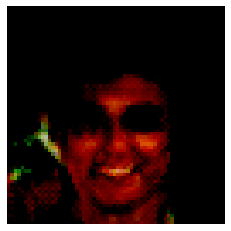

37/50, 37.50789639924194
  G loss: 13.447059631347656
  D loss: 0.2696838974952698

37/50, 37.5868603916614
  G loss: 6.604094505310059
  D loss: 0.03344476968050003

37/50, 37.66582438408086
  G loss: 21.157760620117188
  D loss: 0.0427468977868557

37/50, 37.74478837650032
  G loss: 7.968018531799316
  D loss: 0.004923619795590639

37/50, 37.82375236891977
  G loss: 13.34939956665039
  D loss: 0.011838377453386784

37/50, 37.90271636133923
  G loss: 12.166501998901367
  D loss: 0.0007035158341750503

37/50, 37.981680353758684
  G loss: 10.382096290588379
  D loss: 0.0744619220495224



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


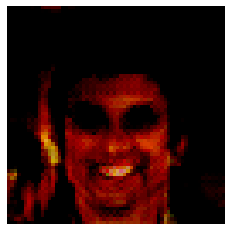

38/50, 38.060644346178144
  G loss: 10.85952377319336
  D loss: 0.0007631732150912285

38/50, 38.1396083385976
  G loss: 16.217744827270508
  D loss: 0.04908492788672447

38/50, 38.21857233101706
  G loss: 8.877229690551758
  D loss: 0.038753442466259

38/50, 38.29753632343651
  G loss: 11.379779815673828
  D loss: 0.000811462348792702

38/50, 38.37650031585597
  G loss: 14.038101196289062
  D loss: 0.05812004208564758

38/50, 38.455464308275424
  G loss: 13.944442749023438
  D loss: 0.014291343279182911



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


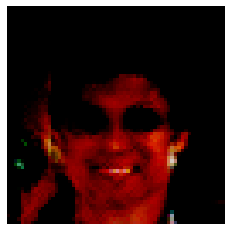

38/50, 38.534428300694884
  G loss: 12.783894538879395
  D loss: 0.03509091958403587

38/50, 38.61339229311434
  G loss: 10.961087226867676
  D loss: 0.0023727279622107744

38/50, 38.6923562855338
  G loss: 9.898592948913574
  D loss: 0.06946694105863571

38/50, 38.77132027795325
  G loss: 8.106419563293457
  D loss: 0.1916712373495102

38/50, 38.85028427037271
  G loss: 4.720823764801025
  D loss: 1.800567388534546

38/50, 38.929248262792164
  G loss: 7.870730876922607
  D loss: 0.03549984097480774



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


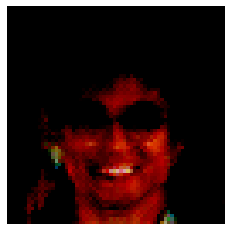

39/50, 39.008212255211625
  G loss: 15.478137969970703
  D loss: 0.3497052788734436

39/50, 39.08717624763108
  G loss: 9.347238540649414
  D loss: 0.003335505723953247

39/50, 39.16614024005054
  G loss: 15.330914497375488
  D loss: 0.0019178519723936915

39/50, 39.24510423246999
  G loss: 9.540853500366211
  D loss: 0.31669414043426514

39/50, 39.32406822488945
  G loss: 15.102846145629883
  D loss: 0.013891549780964851



In [ ]:
G.train()
num_epochs = 50
learning_rate = 1e-3
adversarial_loss = torch.nn.BCELoss()
img_list = []
G_losses = []
D_losses = []
iters = 0
fix_noize = torch.randn(1, latent_size, 1, 1).to(device)
 
optim_G = torch.optim.Adam(G.parameters(), lr=learning_rate)
optim_D = torch.optim.Adam(D.parameters(), lr=learning_rate)
  
for epoch in range(num_epochs):
    for data, _ in loader:
 
        optim_D.zero_grad()
        real_imgs = data.to(device)
        bs = len(data)
        valid = torch.cuda.FloatTensor(data.shape[0]).fill_(1.0)
        output = D(real_imgs).view(-1)
        D_loss_r = adversarial_loss(output, valid)
        D_loss_r.backward()
        
        noize = torch.randn(bs, latent_size, 1, 1).to(device)
        fake = torch.cuda.FloatTensor(data.shape[0]).fill_(0.0)
        gen_imgs = G(noize)
        output = D(gen_imgs.detach()).view(-1)
        D_loss_f = adversarial_loss(output, fake)
        D_loss_f.backward()
        D_loss = D_loss_r + D_loss_f
        optim_D.step()
 
        optim_G.zero_grad() 
        output = D(gen_imgs).view(-1)
        G_loss = adversarial_loss(output, valid)
        G_loss.backward()
        optim_G.step()
 
    
        if iters % 250 == 0:
            print(f'{epoch}/{num_epochs}, {iters/len(loader)}')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())
 
        if iters % 1583 == 0:
            D.eval()
            G.eval()
            draw(fix_noize) 
            torch.save(D.state_dict(), '/content/drive/My Drive/D.pt')
            torch.save(G.state_dict(), '/content/drive/My Drive/G.pt')
            D.train()
            G.train()
        iters += 1

In [ ]:
mas2 = []
for number in range(10):
    vec = torch.randn(1, latent_size, 1, 1).to(device)
    mas2.append(vec)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


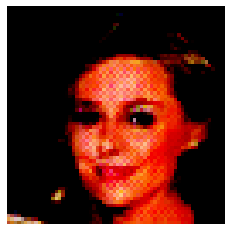

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


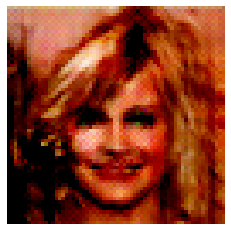

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


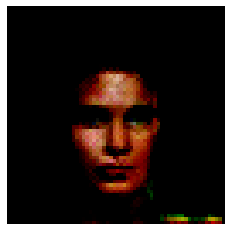

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


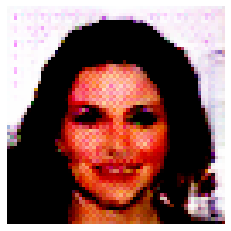

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


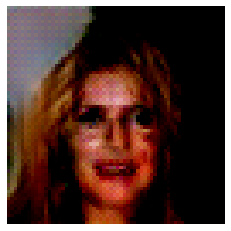

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


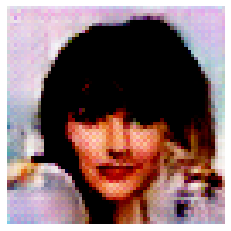

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


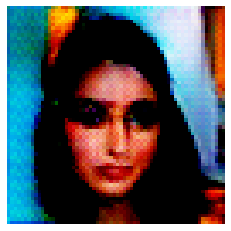

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


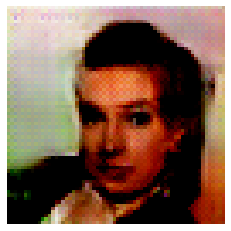

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


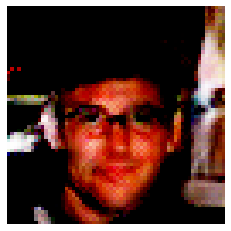

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


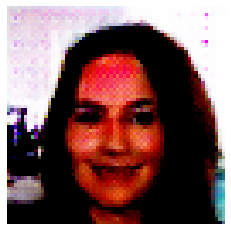

In [ ]:
G.eval()
for vec in mas2:
    draw(vec)